# A Gentle Introduction to Transfer Learning for Image Classification

According to [Andrew Ng](http://www.andrewng.org/), cofounder of Coursera and Adjunct Professor at Stanford, Transfer Learning will be the next driver of Machine Learning commercial success.

[Transfer Learning](http://cs231n.github.io/transfer-learning/) is a Machine Learning technique that allows to reutilize an already trained convolutional neural network (CNN) on a specific dataset and adapt it, or transfer it, to a different dataset. The reason you want to reuse a trained CNN is because it typically takes a long time to train. For example, training [ResNet18](https://arxiv.org/abs/1512.03385) for 30 epochs in 4 NVIDIA K80 GPU [took us 3 days](https://blogs.technet.microsoft.com/machinelearning/2016/11/15/imagenet-deep-neural-network-training-using-microsoft-r-server-and-azure-gpu-vms/). Training ResNet152 for 120 epochs in 4 NVIDIA K80 GPUs takes 4 months. 

In this post we will use [PyTorch](https://github.com/pytorch/pytorch/) to perform transfer learning in different datasets. We will explain the most common strategies to perform transfer learning and we will analyze when you should use each of them. 

**If you want to go directly to the results, scroll to the bottom of the notebook.**

## Transfer learning strategies

In general, there are two strategies to perform transfer learning, and I have not seen a final agreement on the naming. **Finetuning**, which consists of using the pretrained network on the base dataset and train all layers in the target dataset, and **freeze and train**, which consists of leaving all but the last layer frozen (the weights are not updated) and train the last layer. It is also possible to freeze the first couple of layers and finetune the rest, this is due to some evidence indicating that the first layers of the CNN contains [texture filters and color blobs](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). However, in this work we are going to analyze the two extreme cases: training all layers and training only the last layer.

The most common base dataset is [ImageNet](http://image-net.org/), which contains 1.2 million images with 1000 categories. These categories are divided in two big groups, animals and objects. The number of images per category is around 1000. Most deep learning libraries provide CNN models pretrained on ImageNet.  

The image below shows the workflow of a CNN architecture, i.e. ResNet, identifying a cat. The input is an image of 224x224px and 3 channels (RGB), and the output is the label `tabby cat`. The last layer has 1000 units, corresponding to the 1000 classes of ImageNet.
![ResNet CNN](./img/resnet.svg)

In the image below we can see the two mentioned strategies for transfer learning. Here we used a pretrained CNN on ImageNet and adapt it to classify Homer Simpson, using as the target dataset a subset of [the Simpsons Character Data](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset). This subset contains 20 classes with between 300 and 1000 images per class. 

The first step to perform transfer learning is to adapt the number of classes from the base dataset to the target dataset. In the case of the Simpsons dataset, we have to remove the last layer of the network, which contains 1000 units and add a new layer with 20 units. 

Then we can use **freeze and train**, as it is represented in the upper figure, and just train the last layer, or we can **finetune** all layers, as it is represented in the bottom figure.
![Transfer Learning](./img/finetuning_freezing.svg)

## When to use transfer learning

It is difficult to know in which cases one should just train the last layer or finetune the network. In [(Yosinsky et. al., 2014)](http://arxiv.org/abs/1411.1792), the authors address the problem of quantifying the degree to which a particular CNN layer is general or specific in the context of the ImageNet dataset. They found that the the transferability is negatively affected by splitting the network in the middle layers due to coadaptation of these layers. They reported that the transferability gap grows as the distance between tasks increases and finally, they found that initializing the network with transferred weights can improve generalization performance in comparison with training it from zero weights.

As reported in this [tutorial of Karpathy](http://cs231n.github.io/transfer-learning/), these are some guidelines of the different scenarios when using transfer learning in a new dataset:
* **Small and similar images**: When the target dataset is small in comparison with the base dataset and its images are very different, the recommendation is to freeze and train the last layer.
* **Large and similar images**: When the dataset is large and it has similar images the recommendation is finetune. 
* **Small and different images**: In this case the recommendation is freeze and train the last layer or some of the last layers
* **Large and different images**: In this case the recommendation is finetune.

In this notebook, we are going to revisit these strategies using different datasets.



In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

from utils import (
    get_gpu_name, 
    get_number_processors, 
    plot_pytorch_data_stream, 
    create_dataset, 
    available_models, 
    plot_metrics,
    finetune,
    freeze_and_train,
)

print(f"OS: {sys.platform}")
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Number of CPU processors: {get_number_processors()}")
print(f"GPU: {get_gpu_name()}")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model and utilities

The first step is to define the `finetune` and `freeze_and_train` routines. In addition, we list all the models avaialable in pytorch that we could potentially use as a base model.

In [57]:
model_names = available_models()
print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model', 'get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception_v3', 'list_models', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_

The `finetune` function loads a pretrained model, replaces the last layer with a new one matching the number of classes, and trains **all layers**:

```python
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](weights="DEFAULT")
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)

    if num_gpus > 1 and torch.cuda.device_count() > 1:
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler,
                           num_epochs=num_epochs, verbose=verbose)
    return model_ft
```

The `freeze_and_train` function freezes all layers except the last one, then trains **only the final classification layer**:

```python
def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](weights="DEFAULT")
    for param in model_conv.parameters():
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)

    if num_gpus > 1 and torch.cuda.device_count() > 1:
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()
    if num_gpus > 1 and torch.cuda.device_count() > 1:
        params = model_conv.module.fc.parameters()
    else:
        params = model_conv.fc.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler,
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv
```

Both functions are imported from `utils.py` and used directly below.

## Datasets

We are going to use different datasets to test the transfer learning routines. We converted all of them to grayscale to analyze how the network behaves with in this color space. We also had to divide the dataset folders into `train` and `validation`, following the structure of pytorch. All the steps to do this are in the notebook [data_prep.ipynb](data_prep.ipynb).

**Note:** The Simpsons and Dogs vs Cats datasets require a Kaggle API key. See the [README](README.md) for setup instructions.

Links to source:
* [Hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip), 2 classes and 397 images.
* [Simpons](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/data), 20 classes (subset of total) and 19548 images.
* [Dogs vs Cats](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset), 2 classes and 25000 images.
* [Caltech 256](https://data.caltech.edu/records/nyy15-4j048), 257 classes (yeah, I was also surprised) and 30607 images.

In [58]:
DATA_ROOT = "./data"

HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, "hymenoptera_data")
HYMENOPTERA_GRAY_ROOT = os.path.join(DATA_ROOT, "hymenoptera_gray")

SIMPSONS_ROOT = os.path.join(DATA_ROOT, "simpsons", "simpsons")
SIMPSONS_GRAY_ROOT = os.path.join(DATA_ROOT, "simpsons", "simpsons_gray")

DOGS_CATS_ROOT = os.path.join(DATA_ROOT, "dogs_vs_cats", "dogs_vs_cats")
DOGS_CATS_GRAY_ROOT = os.path.join(DATA_ROOT, "dogs_vs_cats", "dogs_vs_cats_gray")

CALTECH256_ROOT = os.path.join(DATA_ROOT, "caltech256", "caltech256")
CALTECH256_GRAY_ROOT = os.path.join(DATA_ROOT, "caltech256", "caltech256_gray")

Here we define the initial parameters.

In [56]:
MODEL_NAME = "resnet18" # "resnet152"
BATCH_SIZE = 256
SETS = ["train", "val"]
NUM_GPUS = 1
EPOCHS = 15
LR = 0.002
LR_STEP = 0.1
LR_EPOCHS = 10
MOMENTUM = 0.9

Now we are going to load each of the datasets, showing some internal stats for each of them.

In [59]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

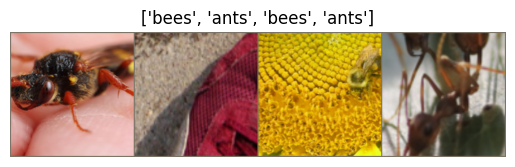

In [60]:
plot_pytorch_data_stream(data_hymenoptera["train"], max_images=4)

In [61]:
data_hymenoptera_gray = create_dataset(HYMENOPTERA_GRAY_ROOT, batch_size=BATCH_SIZE, verbose=False)

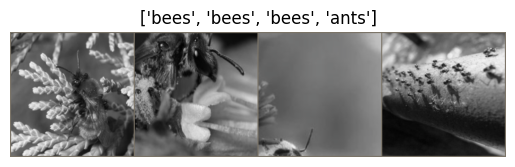

In [62]:
plot_pytorch_data_stream(data_hymenoptera_gray["train"], max_images=4)

In [63]:
data_simpsons = create_dataset(SIMPSONS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

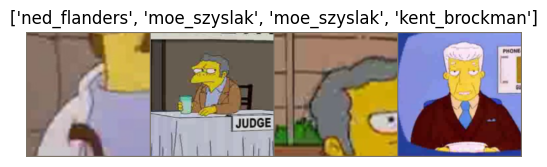

In [64]:
plot_pytorch_data_stream(data_simpsons["train"], max_images=4)

In [65]:
data_simpsons_gray = create_dataset(SIMPSONS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

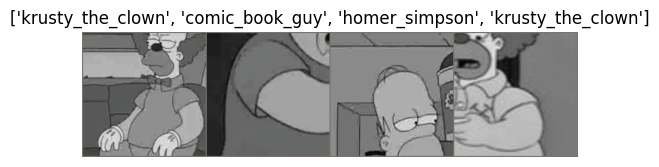

In [66]:
plot_pytorch_data_stream(data_simpsons_gray["train"], max_images=4)

In [67]:
data_dogs_vs_cats = create_dataset(DOGS_CATS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

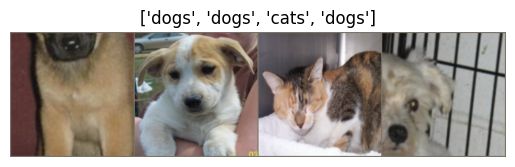

In [68]:
plot_pytorch_data_stream(data_dogs_vs_cats["train"], max_images=4)

In [69]:
data_dogs_vs_cats_gray = create_dataset(DOGS_CATS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

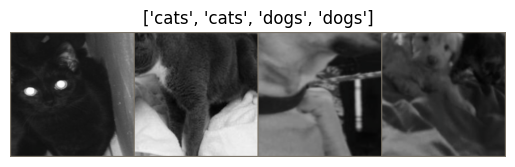

In [70]:
plot_pytorch_data_stream(data_dogs_vs_cats_gray["train"], max_images=4)

In [71]:
data_caltech256 = create_dataset(CALTECH256_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

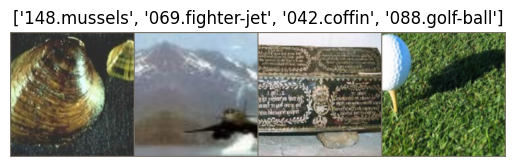

In [72]:
plot_pytorch_data_stream(data_caltech256["train"], max_images=4)

In [73]:
data_caltech256_gray = create_dataset(CALTECH256_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

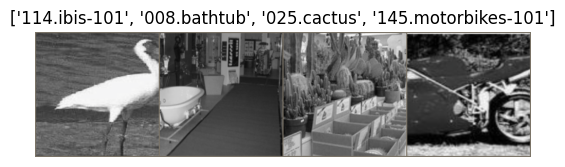

In [74]:
plot_pytorch_data_stream(data_caltech256_gray["train"], max_images=4)

## Training

For each dataset, we are going to compute finetunining and freeze and train. 


In [75]:
val_acc_ft = "Validation accuracy finetuning"
val_acc_fr = "Validation accuracy freezing"
df = pd.DataFrame(columns=[val_acc_ft, val_acc_fr])


### Hymenoptera dataset

In [92]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

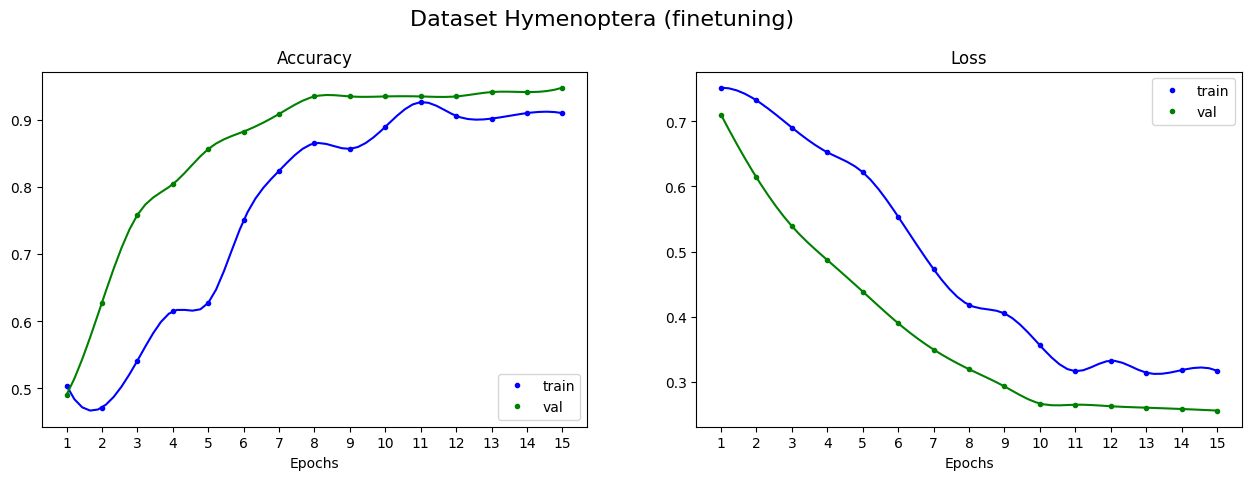

In [93]:
dataset_name = "Dataset Hymenoptera"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [94]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

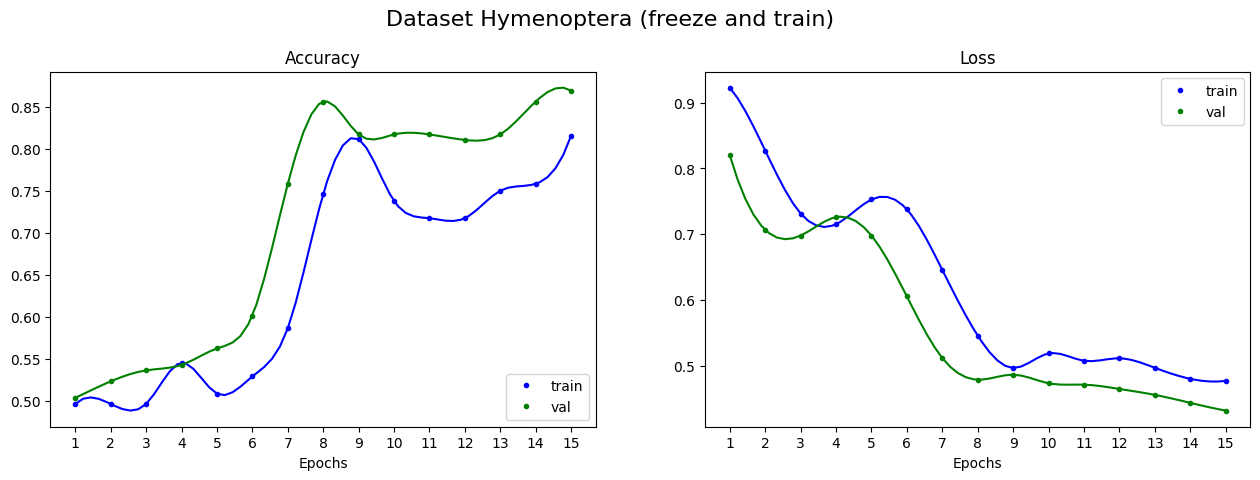

In [95]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

In [96]:
model, metrics = finetune(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

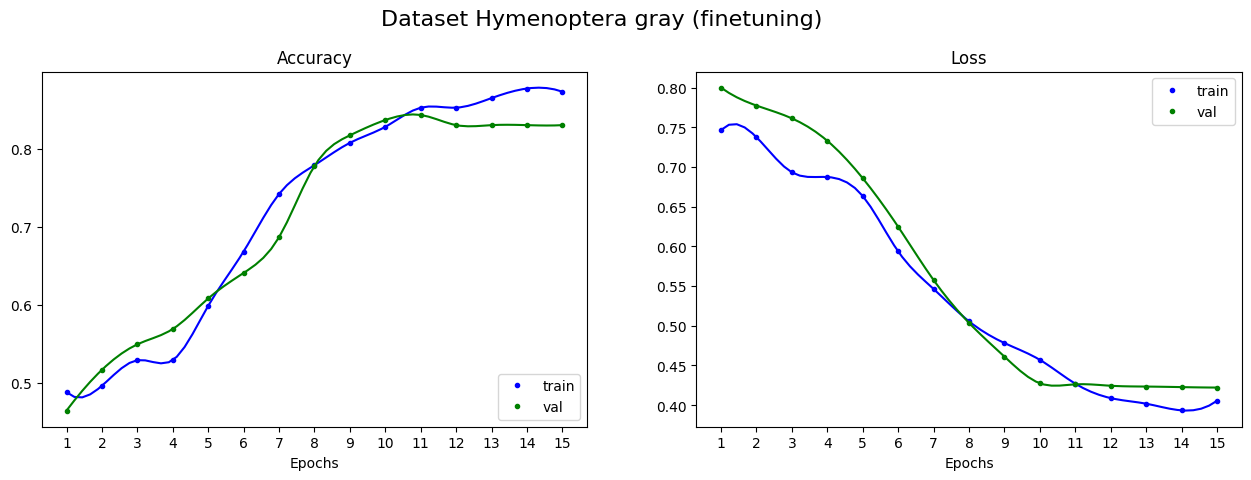

In [97]:
dataset_name = "Dataset Hymenoptera gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [98]:
model, metrics = freeze_and_train(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

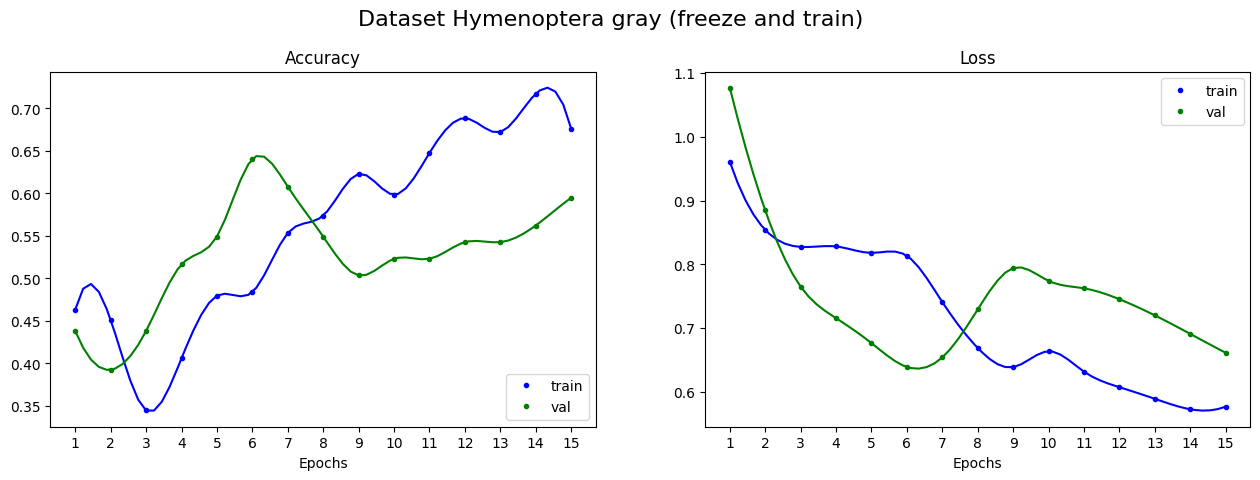

In [99]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

### Simpsons dataset

In [100]:
model, metrics = finetune(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

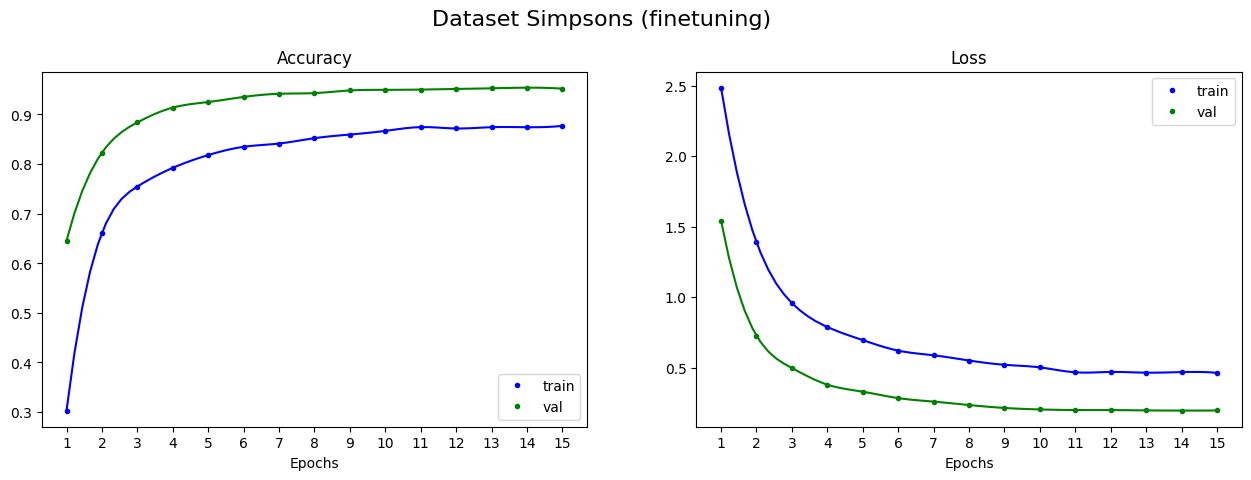

In [101]:
dataset_name = "Dataset Simpsons"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [102]:
model, metrics = freeze_and_train(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

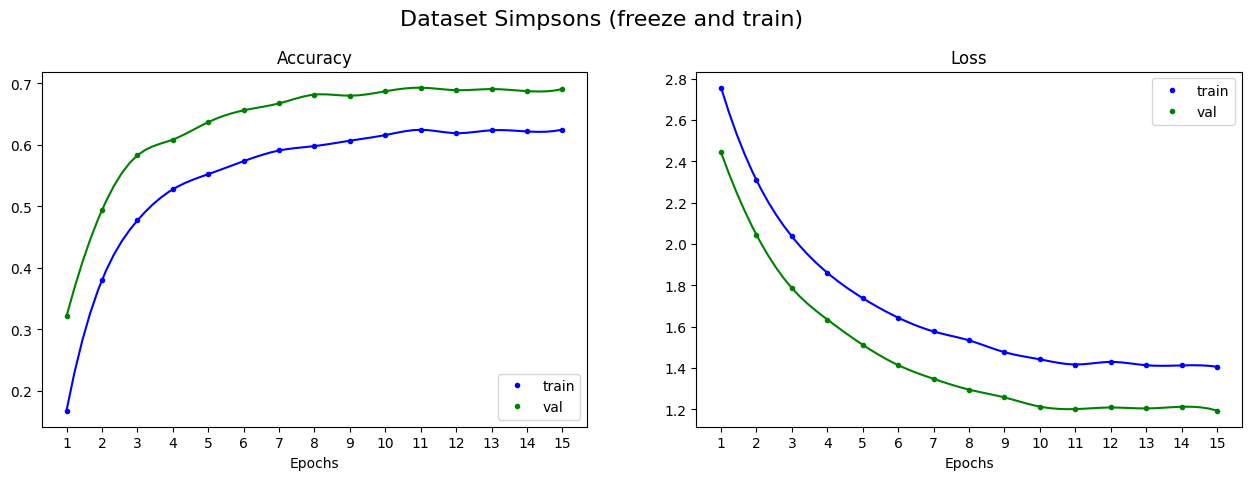

In [103]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

In [104]:
model, metrics = finetune(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

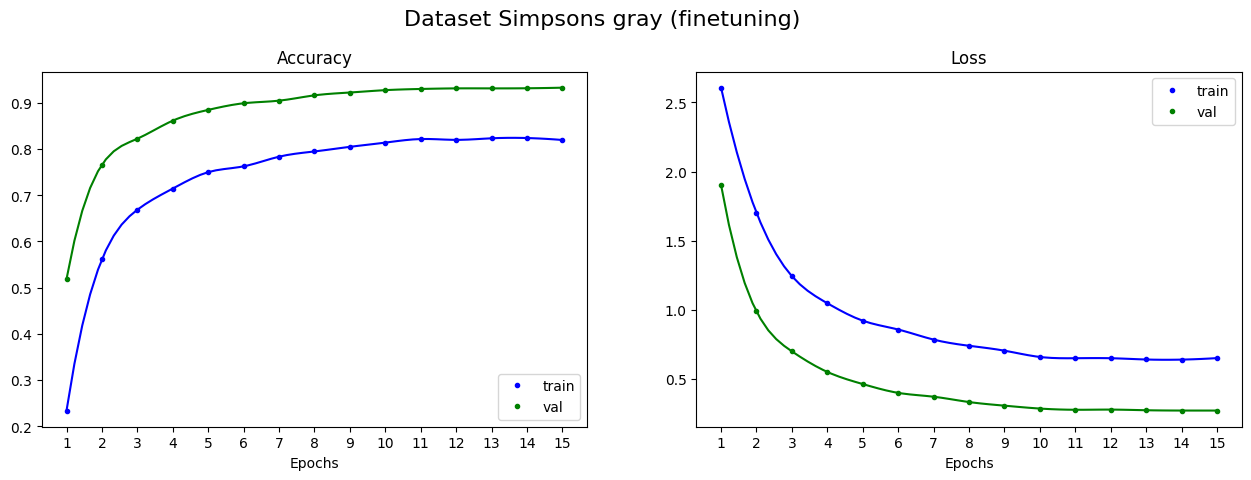

In [105]:
dataset_name = "Dataset Simpsons gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [106]:
model, metrics = freeze_and_train(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

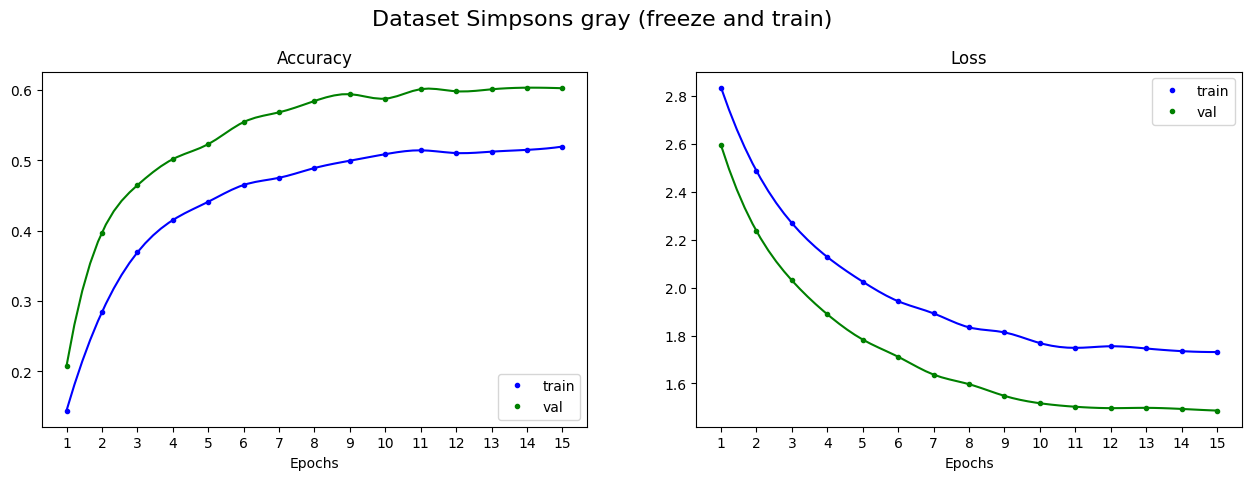

In [107]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

### Dogs vs cats dataset

In [76]:
model, metrics = finetune(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

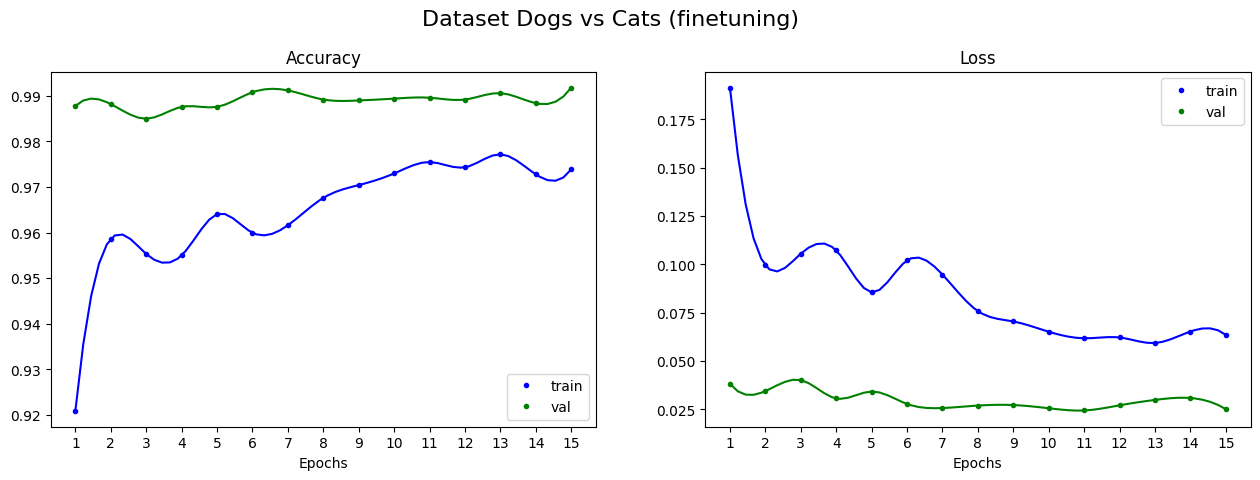

In [77]:
dataset_name = "Dataset Dogs vs Cats"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [78]:
model, metrics = freeze_and_train(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

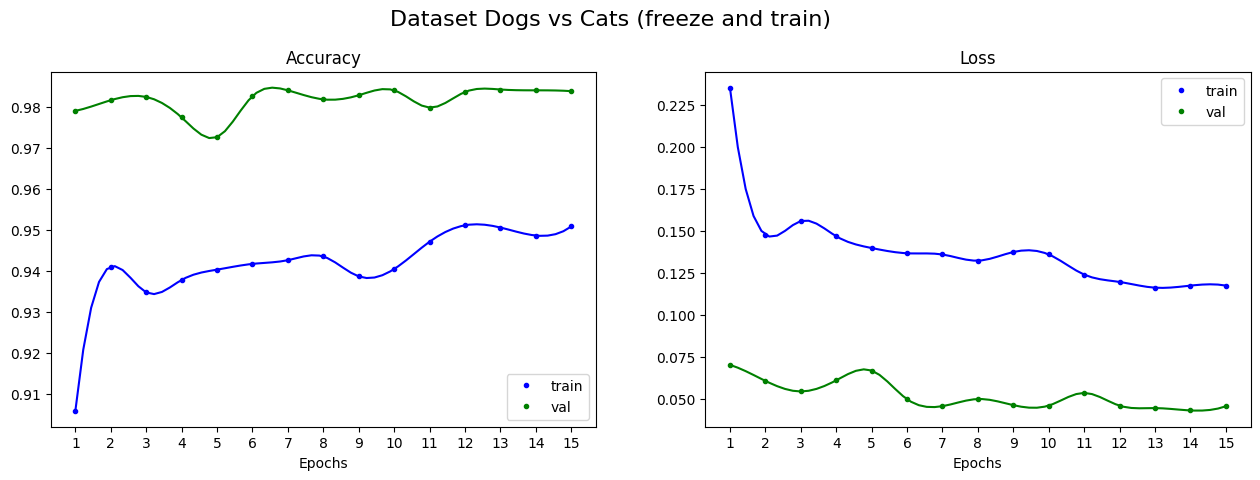

In [79]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

In [80]:
model, metrics = finetune(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

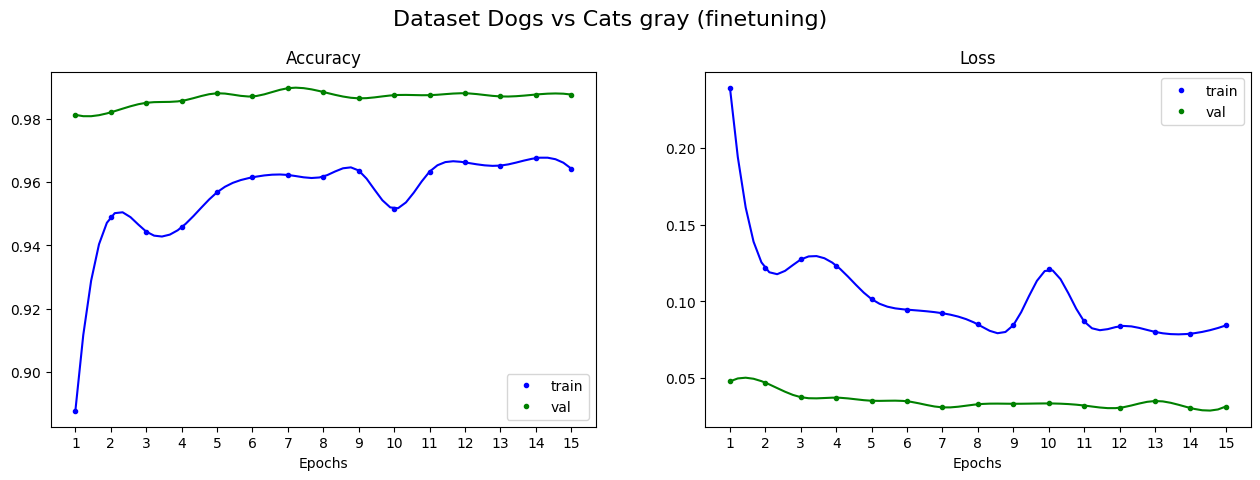

In [81]:
dataset_name = "Dataset Dogs vs Cats gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [82]:
model, metrics = freeze_and_train(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

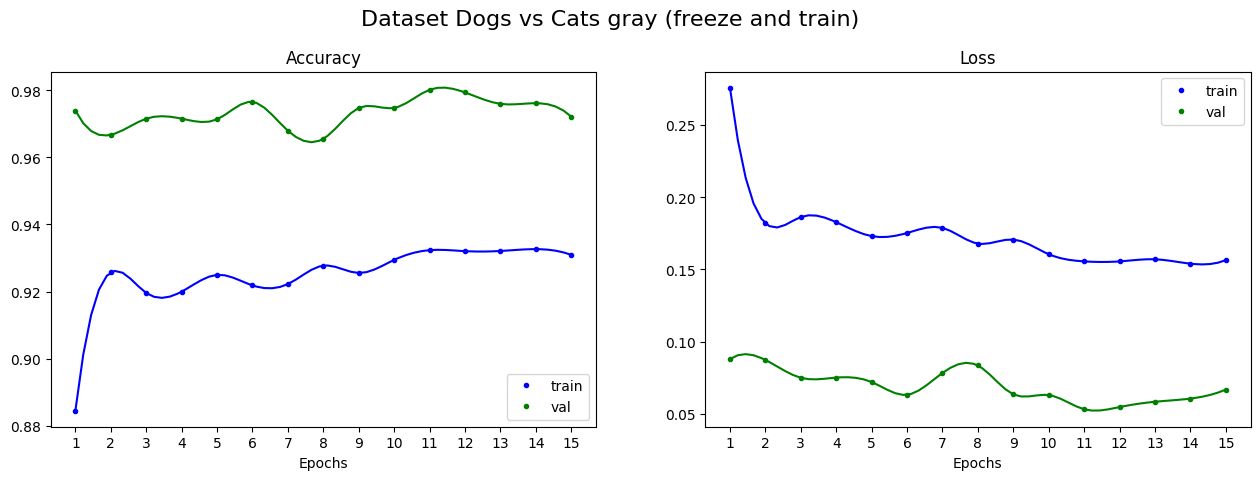

In [83]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

### Caltech256 dataset

In [84]:
model, metrics = finetune(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

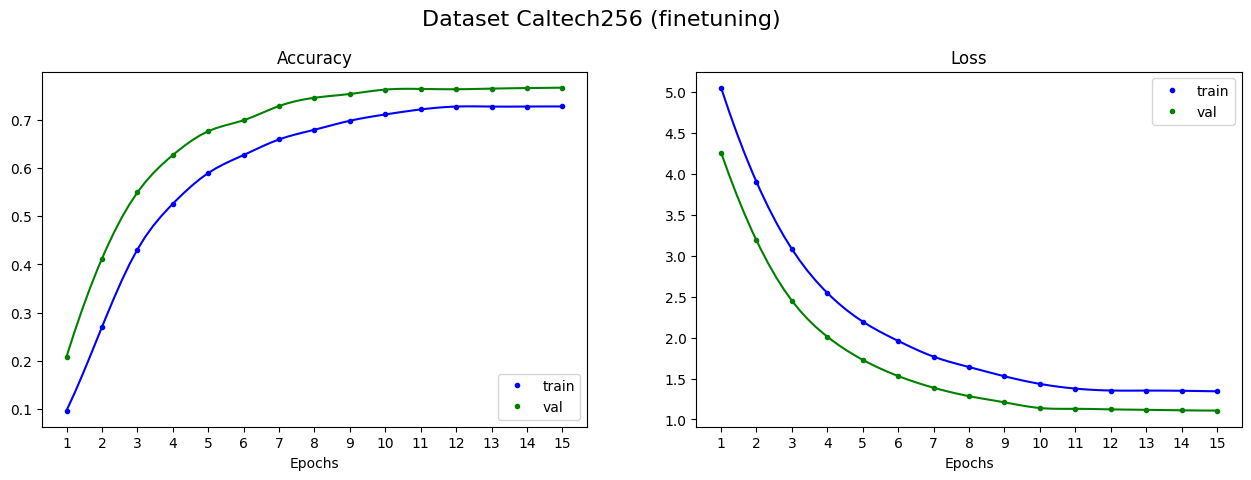

In [85]:
dataset_name = "Dataset Caltech256"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [ ]:
model, metrics = freeze_and_train(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

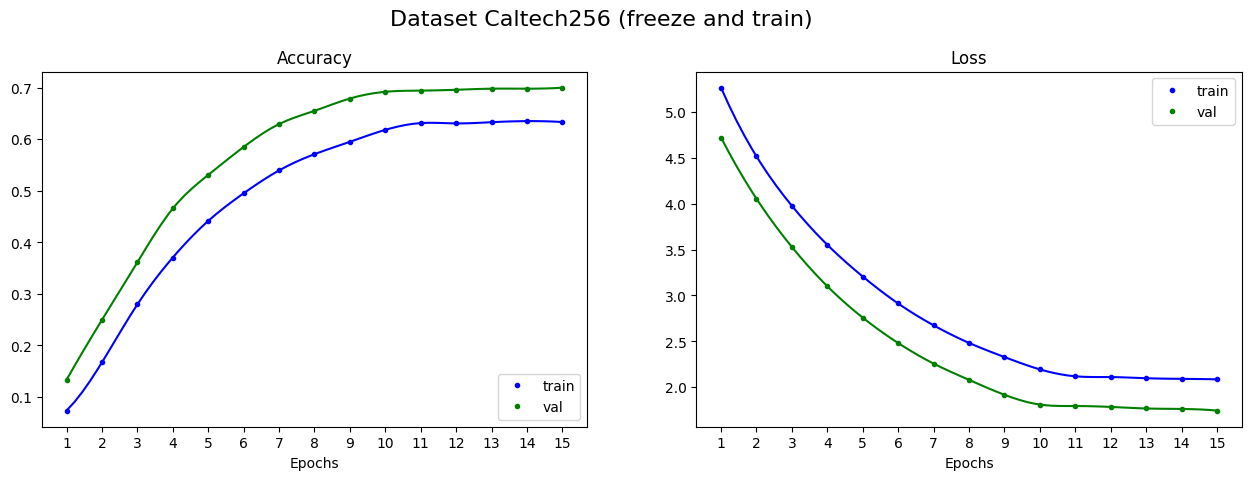

In [87]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

In [88]:
model, metrics = finetune(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

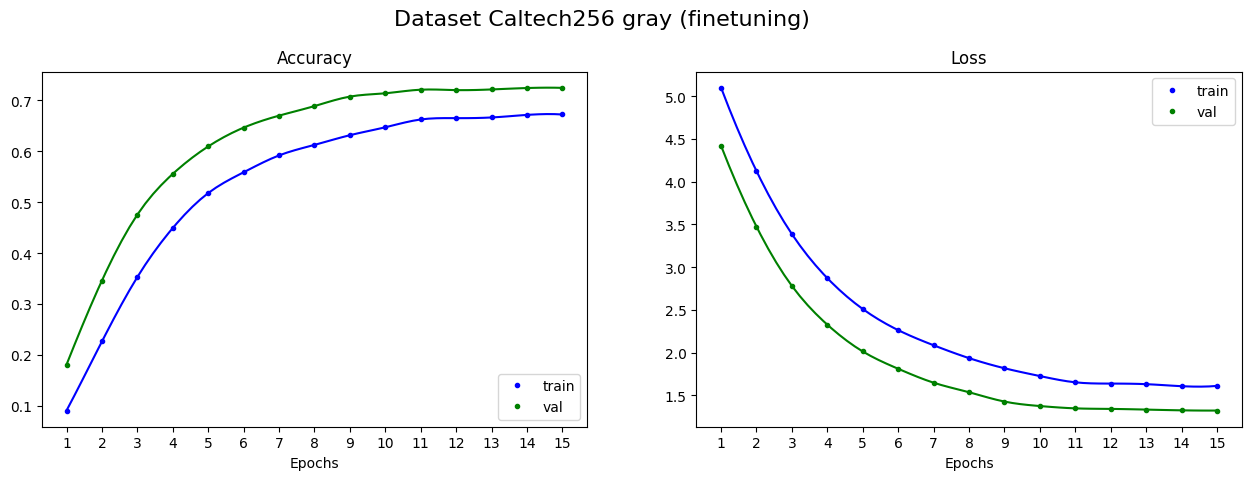

In [89]:
dataset_name = "Dataset Caltech256 gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics["val_acc"])

In [90]:
model, metrics = freeze_and_train(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

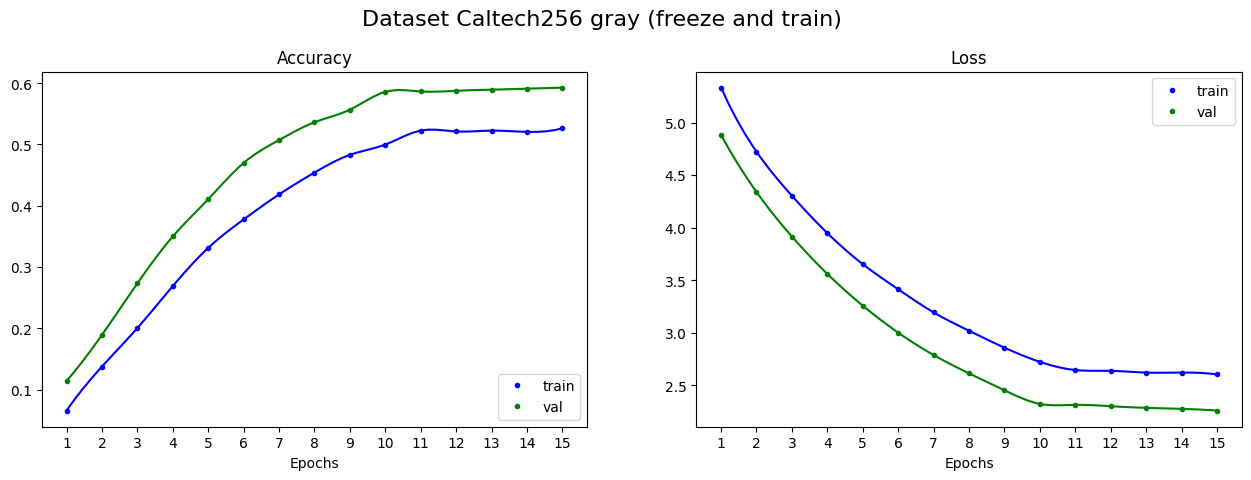

In [91]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics["val_acc"])

### Summary

In [108]:
df

,Validation accuracy finetuning,Validation accuracy freezing
Dataset Dogs vs Cats,0.991782,0.984165
Dataset Dogs vs Cats gray,0.989577,0.980156
Dataset Caltech256,0.766351,0.699804
Dataset Caltech256 gray,0.72482,0.592708
Dataset Hymenoptera,0.947712,0.869281
Dataset Hymenoptera gray,0.843137,0.640523
Dataset Simpsons,0.953964,0.692839
Dataset Simpsons gray,0.932737,0.603069


## Discussion and analysis

In this notebook we used a limited number of datasets with a small network, ResNet18, so it will be premature to generalize the findings to all datasets and networks. However, the findings may shed some light on the problem of when to use transfer learning. In the following table there is a summary of the results.

| Dataset | # of classes | # of images | Val. accuracy finetuning | Val. accuracy freezing | Gap |
| -- | :--: | :--: | :--: | :--: | :--: |
| Dataset Hymenoptera | 2 | 397 | 0.9477 | 0.8693 | 0.0784 |
| Dataset Hymenoptera gray | 2 | 397 | 0.8431 | 0.6405 | 0.2026 |
| Dataset Simpsons | 20 | 19548 | 0.9540 | 0.6928 | 0.2612 |
| Dataset Simpsons gray | 20 | 19548 | 0.9327 | 0.6031 | 0.3296 |
| Dataset Dogs vs Cats | 2 | 25000 | 0.9918 | 0.9842 | 0.0076 |
| Dataset Dogs vs Cats gray | 2 | 25000 | 0.9896 | 0.9802 | 0.0094 |
| Dataset Caltech256 | 257 | 30607 | 0.7664 | 0.6998 | 0.0666 |
| Dataset Caltech256 gray | 257 | 30607 | 0.7248 | 0.5927 | 0.1321 |

### Finetuning always wins

Across all eight experiments, finetuning consistently outperforms freeze and train. This includes the Hymenoptera dataset, where the small size of the dataset (397 images) might suggest that freezing would be safer to avoid overfitting. In practice, finetuning still achieved higher accuracy (0.9477 vs 0.8693), indicating that even small datasets benefit from adapting the full network when starting from pretrained weights.

### Domain similarity is the strongest predictor

The Dogs vs Cats dataset, whose domain is closest to ImageNet (which contains many breeds of dogs and cats), shows the smallest gap between finetuning and freezing (~0.8%). The frozen features are already well-suited for the task, so there is little to gain from updating them. In contrast, the Simpsons dataset shows the largest gap (~26%). Cartoon images with flat colors and exaggerated shapes are very different from ImageNet's natural photographs, so the pretrained features need significant adaptation that only finetuning can provide.

### Grayscale amplifies the freezing penalty

Removing color information consistently hurts accuracy, but the effect is far more severe for freeze and train than for finetuning. For example, in Hymenoptera, finetuning drops ~10% when going to grayscale (0.9477 to 0.8431), while freezing drops ~23% (0.8693 to 0.6405). This makes sense: the pretrained features expect 3-channel RGB input. When presented with grayscale images (replicated to 3 channels), the frozen early layers cannot adapt their color-sensitive filters. Finetuning compensates by adjusting the entire network to work with the reduced information.

### Number of classes and dataset size

Caltech256, with 257 classes and only ~120 images per class on average, presents a challenging scenario. Despite being the largest dataset in total images, the per-class count is small. Finetuning achieved 0.7664, which is reasonable for such a fine-grained task with limited per-class data. Freezing still reached 0.6998, suggesting that ImageNet features provide a solid foundation even for a large number of categories. The Simpsons dataset, with 20 classes and ~1000 images per class, achieved the second-best finetuning accuracy (0.9540), showing that a moderate number of well-represented classes benefits most from transfer learning.

### Practical guidelines

Based on these results:
* **Similar domain (e.g. natural images of animals)**: Both strategies work well. Freezing is a viable quick baseline, finetuning gives a small additional boost.
* **Different domain (e.g. cartoons, synthetic images)**: Finetuning is strongly recommended. Freezing leads to significant accuracy loss.
* **Grayscale or non-standard input**: Finetuning is essential, as frozen features trained on RGB data transfer poorly.
* **Many classes with few images per class**: Finetuning still outperforms freezing, but consider data augmentation or a larger pretrained model to improve absolute accuracy.